# runs permutations on isPC/FC matrices

see above lol -- copied from isPC-vis

## py conversion

In [235]:
#!jupyter nbconvert --to python isPc-permutations.ipynb

[NbConvertApp] Converting notebook isPc-permutations.ipynb to python
[NbConvertApp] Writing 16889 bytes to isPc-permutations.py


## Imports 

In [121]:
import warnings
import sys  
import random
import os
import os.path

import deepdish as dd
import numpy as np
import pandas as pd

import scipy.io
from scipy import stats
from scipy.stats import stats
from scipy.stats import norm, zscore, pearsonr
from scipy.signal import gaussian, convolve

#plotting
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
import seaborn as sns 

# nil and nib 
import nibabel as nib
import nilearn as nil

from nilearn.input_data import NiftiMasker
from nilearn import datasets, plotting
from nilearn.plotting import plot_roi
from nilearn.input_data import NiftiSpheresMasker
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.image import concat_imgs, resample_img, mean_img,index_img
from nilearn import image
from nilearn import masking
from nilearn.plotting import view_img
from nilearn.image import resample_to_img
from nilearn.image import concat_imgs, resample_img, mean_img
from nilearn.plotting import view_img
from nilearn.input_data import NiftiMasker
from nilearn.masking import compute_epi_mask, compute_brain_mask, unmask
from nilearn.plotting import plot_stat_map

# Brainiak # 
from brainiak import image, io 
import brainiak.utils.fmrisim as sim  
from brainiak import image, io
import brainiak.eventseg.event
from brainiak.isc import (isc, isfc, bootstrap_isc, permutation_isc,
                          timeshift_isc, phaseshift_isc,
                          compute_summary_statistic)
from brainiak.io import load_boolean_mask, load_images
from statsmodels.stats.multitest import multipletests

from brainiak.isc import squareform_isfc
%matplotlib inline

In [122]:
random.seed(10)

## custom helper functions 

In [123]:
from utils_anal import load_epi_data, resample_atlas, get_network_labels

## directories 

In [124]:
top_dir = '/jukebox/graziano/coolCatIsaac/MEI'
data_dir = top_dir + "/data"
work_dir = data_dir + '/work'
mask_dir = work_dir + '/masks'
behav_dir = top_dir + '/data/behavioral'
rois_dir = data_dir + "/rois"
fmri_prep = data_dir + '/bids/derivatives/fmriprep'
conf_dir = work_dir + '/confs'
preproc_dir = work_dir + '/preproc'
isc_dir = work_dir + '/isc_dat'


# functions

In [181]:
def perm_matrices(targ_dic, roi, num_perms):
    """
    purpose: get permutations across all matrices for an ROI
    input: target dictionary and the roi for analysis
    return: array of permuted accuracies
    """
    num_subs = targ_dic[roi].shape[2]
    perm_arr = []

    for perm in range(num_perms):
        # Transpose input data to compute intersubject pattern correlation
        ispcs = isfc(np.rollaxis(targ_dic[roi], 1, 0),
                            pairwise=False, vectorize_isfcs=False)

        ## create random array of 1s and 0s to randomly sign flip each matrix
        rand_arr = np.random.choice([-1, 1], size=num_subs, replace=True)
        # add dimensions to rand_arr so that it can be broadcast to each matrix
        result = rand_arr[:, np.newaxis, np.newaxis] * ispcs
        # get the average across the 18, 13, 13 matrix -- results should be 13 x 13
        av_across_subs = np.nanmean(result, axis = 0)
        # Convert these directly to condensed ISFCs (and ISCs)
        ispcs_c, iscs = squareform_isfc(av_across_subs)
        print(f"Condensed ISFCs shape: {ispcs_c.shape}, "
              f"ISCs shape: {iscs.shape}")
        ## get shape for transformation later
        iscs_shape = iscs.shape[0]
        perm_arr.append(np.hstack((ispcs_c, iscs)))
    perm_arr = np.vstack(perm_arr) 
    return perm_arr, iscs_shape
    

# ROI

### load data

In [237]:
#load
#roi_bpress_ispc = np.load(f'{isc_dir}/roi_bpress_ispc.npy', allow_pickle = True).item()
roi_bpress_ispc = np.load(f'{isc_dir}/targ_net_roi_bpress_ispc.npy', allow_pickle = True).item()
print(f'total keys: {len(list(roi_bpress_ispc.keys()))}')

total networks: 16


In [245]:
anal_type = 'ROI' # or 'NETWORK'

targ_cond = "internal"
# set movie
targ_mov = 'office'# ['sherlock', 'office', 'oragami', 'shrek', 'brushing', 'cake']
# set hemisphere (onlfy for net)
hemi = 'R'
# set target run 
targ_run = 1 
# set ROI
roi = 'LH_Default_PFC_11'

targ_dic = {} 
if anal_type == "NETWORK":
    targ_keys = [key for key in list(roi_bpress_ispc.keys()) if key[-8:] == targ_cond]  
    targ_keys = [key for key in targ_keys if key[:1] == hemi]  
    for key in targ_keys:
        targ_dic[key] = roi_bpress_ispc[key][targ_run][targ_mov]
elif anal_type == 'ROI':
    targ_keys = [key for key in list(roi_bpress_ispc.keys()) if key[-8:] == targ_cond] 
    for key in targ_keys:
        targ_dic[key[:-9]] = roi_bpress_ispc[key][targ_run][targ_mov]
else:
    print('set anal type')

In [242]:
print(f'total networks: {len(list(targ_dic.keys()))}  \n {targ_mov} {targ_run} \n {targ_cond}')
print(f' subjects included: {targ_dic[list(targ_dic.keys())[0]].shape[2]}') 

total networks: 8  
 office 1 
 internal
 subjects included: 18


### start anal

In [243]:
targ_dic.keys()

dict_keys(['RH_Cont_Par_2', 'LH_Default_PFC_11', 'RH_Cont_PFCl_6', 'RH_Cont_PFCl_7', 'RH_DorsAttn_FEF_2', 'RH_DorsAttn_Post_8', 'LH_Default_PFC_7', 'LH_Default_pCunPCC_4'])

### start 

In [247]:
num_perm = 10
# get permutated accuracies 
perm_mat, isc_shape = perm_matrices(targ_dic, roi, num_perm)
# get the maximum of each permutation test. This controls across all timepoints -- most stringent.
# should use this one or perm_mat? subtle nuance
max_perm = np.max(perm_mat, axis=1)
## get the off diagnonal for plotting [not really important]
perm_mat_c = np.max(perm_mat, axis=0)
## save perm_mat for fun


Condensed ISFCs shape: (78,), ISCs shape: (13,)
Condensed ISFCs shape: (78,), ISCs shape: (13,)
Condensed ISFCs shape: (78,), ISCs shape: (13,)
Condensed ISFCs shape: (78,), ISCs shape: (13,)
Condensed ISFCs shape: (78,), ISCs shape: (13,)
Condensed ISFCs shape: (78,), ISCs shape: (13,)
Condensed ISFCs shape: (78,), ISCs shape: (13,)
Condensed ISFCs shape: (78,), ISCs shape: (13,)
Condensed ISFCs shape: (78,), ISCs shape: (13,)
Condensed ISFCs shape: (78,), ISCs shape: (13,)


In [248]:
# get actual correlation matrix 
ispcs = isfc(np.rollaxis(targ_dic[roi], 1, 0),
                    pairwise=False, vectorize_isfcs=False,
                    summary_statistic='mean')

In [249]:
## flatten and concatenate
ispcs_c, iscs = squareform_isfc(ispcs)
cat_ispcs = np.hstack((ispcs_c, iscs))
## get p-values 

In [250]:
pval = .05
## the current val must beat ALL timepoints in ALL simulations 
sig_vals =  [(np.sum(val < perm_mat)) / perm_mat.shape[0] for val in cat_ispcs]
sig_val_bin = [1 if val < pval else 0 for val in sig_vals ]    

In [251]:
# Convert these directly back to redundant ISFCs
off_diag = np.array(sig_val_bin[:-isc_shape])
diag = np.array(sig_val_bin[-isc_shape:])
sig_mat_r = squareform_isfc(off_diag, diag)
print(f"Converted redundant ISFCs shape: {sig_mat_r.shape}")

Converted redundant ISFCs shape: (13, 13)


In [252]:
mats = np.dstack((sig_mat_r, ispcs))

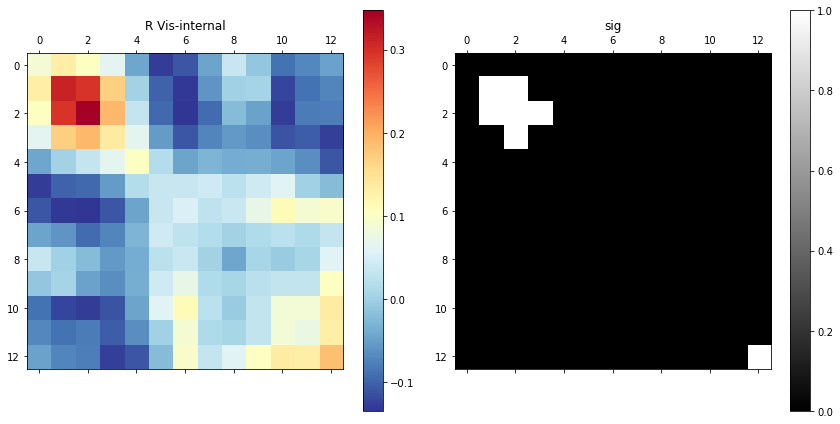

In [207]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

image1 = axs[0].matshow(ispcs, cmap='RdYlBu_r')
axs[0].set_title(f'{roi}')
cbar1 = plt.colorbar(image1, ax=axs[0])

image2 = axs[1].matshow(sig_mat_r, cmap='binary_r')
axs[1].set_title('sig')
cbar1 = plt.colorbar(image2, ax=axs[1])

# Adjust spacing between subplots and colorbars
plt.tight_layout()
plt.show()

# visualize - across video

In [254]:
f'{isc_dir}/{targ_cond}_{roi}_run{targ_run}.npy'

'/jukebox/graziano/coolCatIsaac/MEI/data/work/isc_dat/internal_LH_Default_PFC_11_run1.npy'

In [262]:
roi_across_vids = np.load(f'{isc_dir}/{targ_cond}_{roi}_run{targ_run}.npy', allow_pickle = True).item()

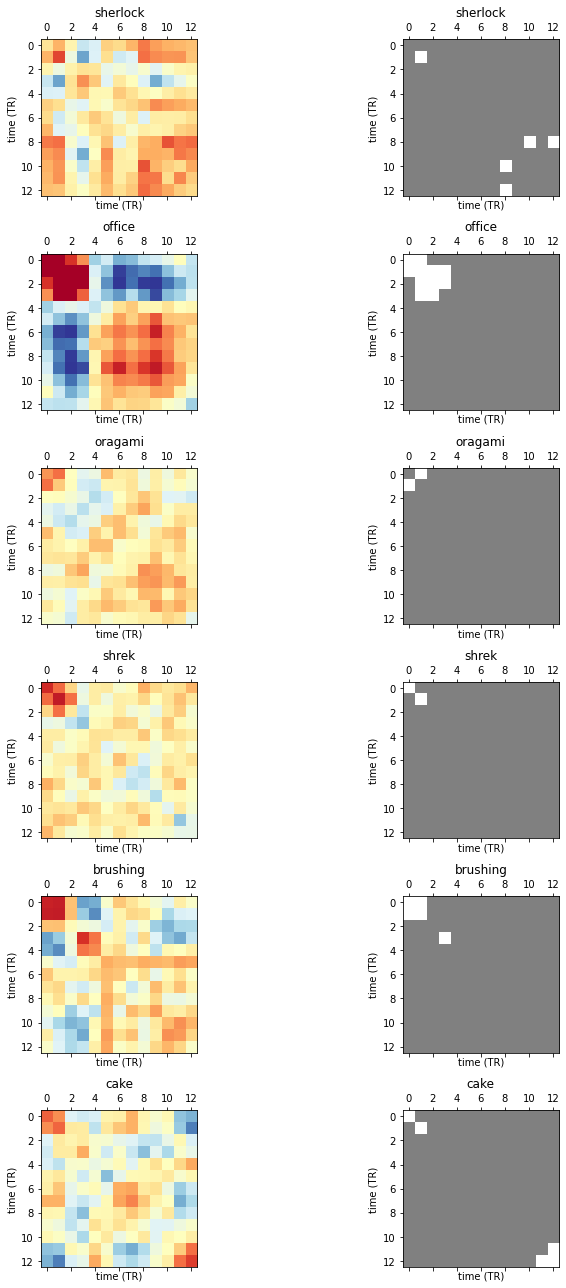

In [274]:
fig, axs = plt.subplots(6, 2, figsize=(12, 18))

vmin= -.3
vmax= .3

for idx, key in enumerate(list(roi_across_vids.keys())):
    mov = roi_across_vids[key]
    # First plot: Matrix
    title = f'{roi}'  # Choose the appropriate title
    axs[idx, 0].matshow(mov[...,1], vmin=vmin, vmax=vmax, cmap='RdYlBu_r')
    axs[idx, 0].set_xlabel('time (TR)')
    axs[idx, 0].set_ylabel('time (TR)')
    axs[idx, 0].set_title(key)
    
    axs[idx, 1].matshow(mov[...,0], vmin=vmin, vmax=vmax, cmap='binary_r')
    axs[idx, 1].set_xlabel('time (TR)')
    axs[idx, 1].set_ylabel('time (TR)')
    axs[idx, 1].set_title(key)
    #axs[int(ind / plot_col), ind % plot_col].set_xticks([])
    #axs[int(ind / plot_col), ind % plot_col].set_yticks([])

# Adjust spacing between subplots and colorbars
plt.tight_layout()
plt.show()

# Visualize - across ROI

In [275]:
#load
#roi_bpress_ispc = np.load(f'{isc_dir}/roi_bpress_ispc.npy', allow_pickle = True).item()
roi_bpress_ispc = np.load(f'{isc_dir}/targ_net_roi_bpress_ispc.npy', allow_pickle = True).item()
print(f'total keys: {len(list(roi_bpress_ispc.keys()))}')

total keys: 16


In [280]:
anal_type = 'ROI' # or 'NETWORK'

targ_cond = "external"
# set movie
targ_mov = 'office'# ['sherlock', 'office', 'oragami', 'shrek', 'brushing', 'cake']
# set hemisphere (onlfy for net)
hemi = 'R'
# set target run 
targ_run = 1 
# set ROI
roi = 'LH_Default_PFC_11'

targ_dic = {} 
if anal_type == "NETWORK":
    targ_keys = [key for key in list(roi_bpress_ispc.keys()) if key[-8:] == targ_cond]  
    targ_keys = [key for key in targ_keys if key[:1] == hemi]  
    for key in targ_keys:
        targ_dic[key] = roi_bpress_ispc[key][targ_run][targ_mov]
elif anal_type == 'ROI':
    targ_keys = [key for key in list(roi_bpress_ispc.keys()) if key[-8:] == targ_cond] 
    for key in targ_keys:
        targ_dic[key[:-9]] = roi_bpress_ispc[key][targ_run][targ_mov]
else:
    print('set anal type')

/jukebox/pkgs/PYGER/base/envs/0.11.0/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


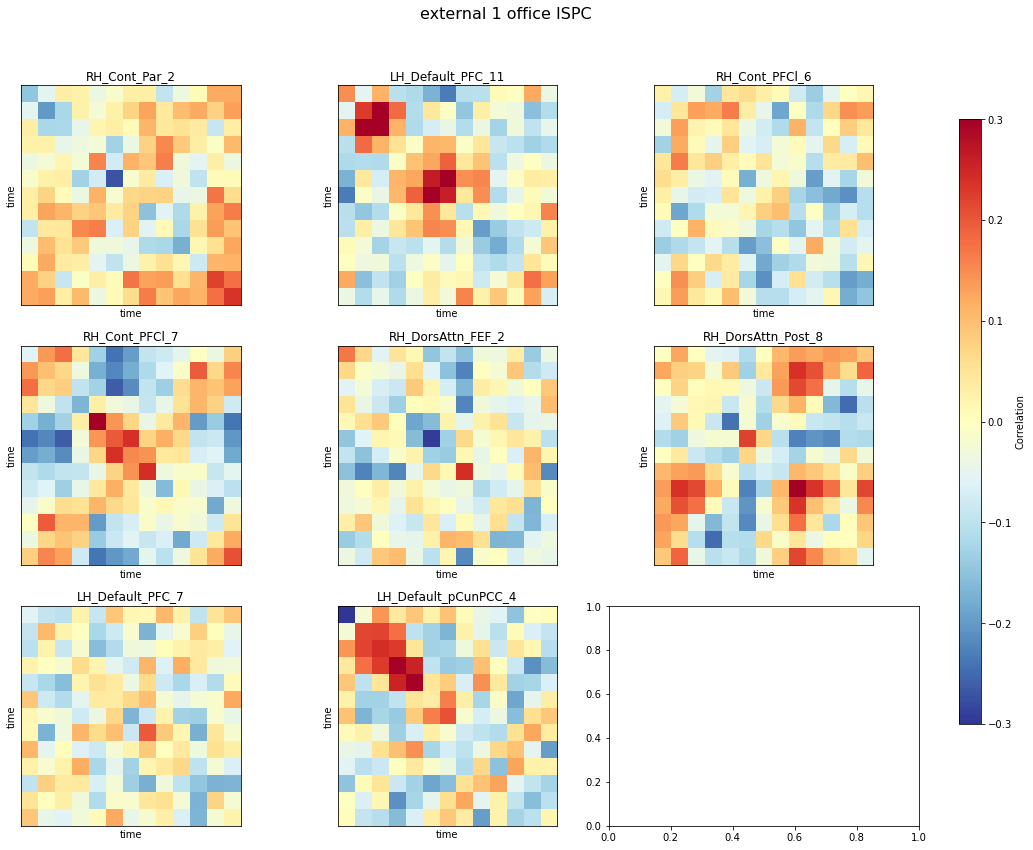

In [281]:
plot_row = 3
plot_col = 3
sub_plot_num = 5

# Plot time-point-by-time-point intersubject pattern correlation
vmin, vmax = -0.3, 0.3

fig, axs = plt.subplots(plot_row, plot_col, figsize=(15, 12))

for ind, roi in enumerate(targ_dic):
    # calculate ispc
    # Transpose input data to compute intersubject pattern correlation
    ispcs = isfc(np.rollaxis(targ_dic[roi], 1, 0),
                        pairwise=False, vectorize_isfcs=False,
                        summary_statistic='mean')

    
    # First plot: Matrix
    title = f'{roi}'  # Choose the appropriate title
    image = axs[int(ind / plot_col), ind % plot_col].matshow(ispcs, vmin=vmin, vmax=vmax, cmap='RdYlBu_r')
    axs[int(ind / plot_col), ind % plot_col].set_title(title)
    axs[int(ind / plot_col), ind % plot_col].set_xticks([])
    axs[int(ind / plot_col), ind % plot_col].set_yticks([])
    axs[int(ind / plot_col), ind % plot_col].set_xlabel('time')
    axs[int(ind / plot_col), ind % plot_col].set_ylabel('time')
    #cbar = plt.colorbar(image, ax=axs[0])  # Add colorbar
    #cbar.set_label('Correlation')  # Set colorbar label

# Main title for the entire plot
plt.suptitle(f'{targ_cond} {targ_run} {targ_mov} ISPC', fontsize=16)


# Add a single colorbar for all subplots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Adjust the position and size of the colorbar
cbar = plt.colorbar(image, cax=cbar_ax)
cbar.set_label('Correlation')

plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust the layout to accommodate the main title
plt.show()
    
    

## One Network

In [29]:
test = np.load(f'{isc_dir}/roi_bpress_ispc.npy', allow_pickle = True).item()
#x = np.load(f'{isc_dir}/ext_isc.npz', mmap_mode='r')

In [23]:
#anal = m_rep_int[4]['sherlock']
anal = m_rep_ext[1]['sherlock']
anal.shape

(13, 1124, 9)

In [24]:
# Transpose input data to compute intersubject pattern correlation
ispcs = isfc(np.rollaxis(anal, 1, 0),
                    pairwise=False, vectorize_isfcs=False,
                    summary_statistic='mean')

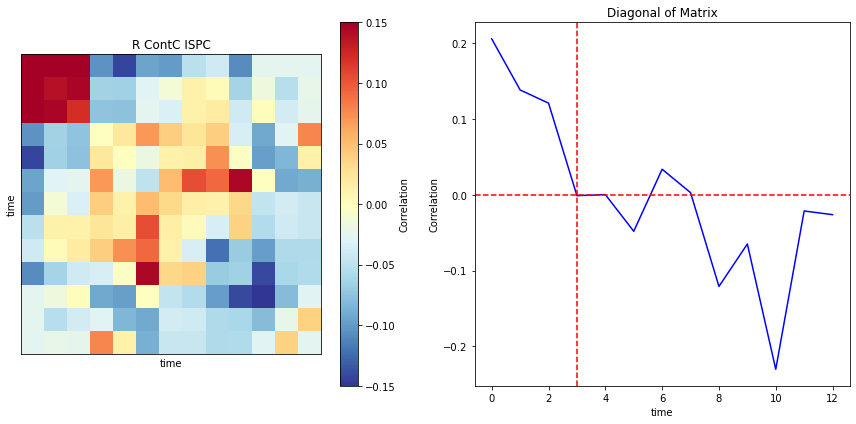

In [25]:
# Plot time-point-by-time-point intersubject pattern correlation
vmin, vmax = -0.15, 0.15

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First plot: Matrix
ispc = ispcs  # Choose the matrix to plot (intact_ispcs or scram_ispcs)
title = f'{net_lab} ISPC'  # Choose the appropriate title
image = axs[0].matshow(ispc, vmin=vmin, vmax=vmax, cmap='RdYlBu_r')
axs[0].set_title(title)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_xlabel('time')
axs[0].set_ylabel('time')
cbar = plt.colorbar(image, ax=axs[0])  # Add colorbar
cbar.set_label('Correlation')  # Set colorbar label

# Second plot: Seaborn lineplot with vertical line
diagonal = np.diagonal(ispc)
time_points = np.arange(len(diagonal))
axs[1] = sns.lineplot(x=time_points, y=diagonal, color='blue')
axs[1].set_title('Diagonal of Matrix')
axs[1].set_xlabel('time')
axs[1].set_ylabel('Correlation')
axs[1].axvline(x=3, color='red', linestyle='--')  # Vertical line at the third tick
axs[1].axhline(y=0, color='red', linestyle='--')  # Horizotnal line at 0


plt.tight_layout()
plt.show()


# Plot networks

### load atlas 

In [24]:
num_parc = 400

## should be 17 to run
num_net= 7

In [25]:
## fetch dataset
dataset = datasets.fetch_atlas_schaefer_2018(n_rois=num_parc, yeo_networks = num_net)

# get nii dataset location
atlas_filename = dataset.maps
## get *ROI* atlas labels
labels = dataset.labels

# resample loaded atlas 
atlas_nii, atlas_img = resample_atlas(atlas_filename, fmri_prep)

Loading data from /jukebox/graziano/coolCatIsaac/MEI/data/bids/derivatives/fmriprep/sub-007/ses-01/func/sub-007_ses-01_task-None_run-02_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz
shape of run 2 is (78, 93, 65, 369) 

count parc:401
shape of atlas nii object (78, 93, 65)


### get network labels

In [26]:
# Load in network labels for each parcell, ALL network labels, and the middle parcel within each network
networks, network_labels, network_idxs = get_network_labels(num_parc, num_net)


two networks: ['L Vis', 'L SomMot'] 
 total nets: 14


In [11]:
# **7 NETWORK Get labels for parcels in left DMN A network** ## 
net_lab = 'R DorsAttn'

## Target Conditions
targ_cond = "External"

## movie repetitions ##
#m_reps = 1
targ_run = 1

## Get labels associated with the target network ## 
targ_net = (np.array(networks) == net_lab).nonzero()[0] + 1


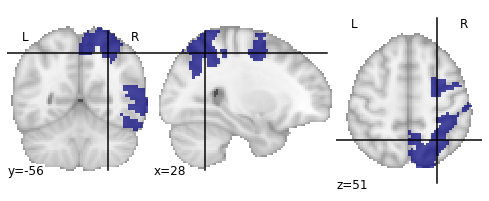

In [13]:
# Create an empty that is the shape of d
roi_tem = np.zeros(atlas_nii.shape)
# set all cases where parcel is equal to roi_num, equal to one, everything else zero (creates a mask)
for parcel in targ_net:
    roi_tem[atlas_img == parcel] = 1
    
# Create a nift image of the mask
roi_img = nib.Nifti1Image(roi_tem, affine = atlas_nii.affine, header = atlas_nii.header)
#nib.save(roi_img, rois_dir+'/'+ roi_name.decode("utf-8"))


mPFC_coords = (10,10, 45)
pcc_coords = (10,-40, 45)

#plot_roi(roi_img,cut_coords = pcc_coords)
plot_roi(roi_img)